In [1]:
import numpy as np
import pandas as pd

import time
import os

import albumentations as albu
from albumentations.pytorch import ToTensor
import PIL
import cv2 as cv

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
from torch import nn
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
from torch.optim import Adam,lr_scheduler
import torchvision.transforms as transforms

from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import Conv2dStaticSamePadding, get_model_params

from PIL import Image

from tqdm import tqdm_notebook, tqdm

## Load the Dataset

In [2]:
HOST = "app.verta.ai"

PROJECT_NAME = "BengaliAI"
EXPERIMENT_NAME = "MobileNet"

In [3]:
os.environ['VERTA_EMAIL'] = 'astakhova.aleksandra@gmail.com'
os.environ['VERTA_DEV_KEY'] = 'd7ee32b5-bbd0-4c4c-a2ec-a070848021be'

In [4]:
from verta import Client
from verta.utils import ModelAPI

client = Client(HOST)
proj = client.set_project(PROJECT_NAME)
expt = client.set_experiment(EXPERIMENT_NAME)
run = client.set_experiment_run()

run.log_tag('MobileNet')

set email from environment
set developer key from environment
connection successfully established
set existing Project: BengaliAI
created new Experiment: MobileNet
created new ExperimentRun: Run 308161579760832186156


In [5]:
# setup the input data folder
DATA_PATH = './data/'

In [6]:
# load the dataframes with labels
train_labels = pd.read_csv(DATA_PATH + 'train.csv')
test_labels = pd.read_csv(DATA_PATH + 'test.csv')
class_map = pd.read_csv(DATA_PATH + 'class_map.csv')
sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [7]:
class_map.head()

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


In [8]:
def load_images():
    '''
    Helper function to load all train and test images
    '''
    train_list = []
    for i in range(0,4):
        train_list.append(pd.read_parquet(DATA_PATH + 'train_image_data_{}.parquet'.format(i)))
    train = pd.concat(train_list, ignore_index=True)
    
    test_list = []
    for i in range(0,4):
        test_list.append(pd.read_parquet(DATA_PATH + 'test_image_data_{}.parquet'.format(i)))
    test = pd.concat(test_list, ignore_index=True)
    
    return train, test

In [9]:
train, test = load_images()

## Image Preprocessing and Augmentations

In [10]:
# setup image hight and width
HEIGHT = 137
WIDTH = 236
SIZE = 128

transform = transforms.Compose([ transforms.CenterCrop(SIZE), transforms.ToTensor()])

## Define the Dataset

Create the custom dataset:

In [11]:
def get_image(idx, df, labels):
    '''
    Helper function to get the image and label from the training set
    '''
    # get the image id by idx
    image_id = df.iloc[idx].image_id
    # get the image by id
    img = df[df.image_id == image_id].values[:, 1:].reshape(HEIGHT, WIDTH).astype(float)
    # get the labels
    row = labels[labels.image_id == image_id]
    labels = row['grapheme_root'].values[0], \
    row['vowel_diacritic'].values[0], \
    row['consonant_diacritic'].values[0]
    
    return img, labels

def get_validation(idx, df):
    '''
    Helper function to get the validation image and image_id from the test set
    '''
    # get the image id by idx
    image_id = df.iloc[idx].image_id
    # get the image by id
    img = df[df.image_id == image_id].values[:, 1:].reshape(HEIGHT, WIDTH).astype(float)
    return img, image_id

class BengaliDataset(Dataset):
    '''
    Create custom Bengali dataset
    '''
    def __init__(self, df_images, transform, df_labels = None, validation = False):
        self.df_images = df_images
        self.df_labels = df_labels
        self.transform = transform
        self.validation = validation

    def __len__(self):
        return len(self.df_images)

    def __getitem__(self, idx):
        if not self.validation:
            img, label = get_image(idx, self.df_images, self.df_labels)
            
            if self.transform:
                img = self.transform(Image.fromarray(img))
            
            return img, label
        else:
            img, image_id = get_validation(idx, self.df_images)
            
            if self.transform:
                img = self.transform(Image.fromarray(img))
                
            return img, image_id

Try to get some images and labels from the dataset:

In [12]:
# initialize train dataset
train_dataset = BengaliDataset(train, transform, train_labels)
sample_trainloader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)

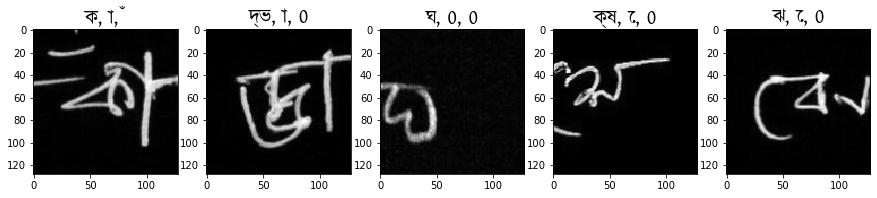

In [13]:
# plot sample train data
for img, labels in sample_trainloader:
    
    fig, axs = plt.subplots(1, img.shape[0], figsize=(15,10))
    for i in range(0, img.shape[0]):
        axs[i].imshow(TF.to_pil_image(img[i].reshape(SIZE, SIZE)), cmap='gray')
        
        prop = FontProperties()
        prop.set_file('./kalpurush.ttf')
        grapheme_root = class_map[(class_map.component_type == 'grapheme_root') \
                                  & (class_map.label == int(labels[0][i]))].component.values[0]
        
        vowel_diacritic = class_map[(class_map.component_type == 'vowel_diacritic') \
                                  & (class_map.label == int(labels[1][i]))].component.values[0]
        
        consonant_diacritic = class_map[(class_map.component_type == 'consonant_diacritic') \
                                  & (class_map.label == int(labels[2][i]))].component.values[0]
        
        axs[i].set_title('{}, {}, {}'.format(grapheme_root, vowel_diacritic, consonant_diacritic), 
                         fontproperties=prop, fontsize=20)
    break;

## Define the Model

Load the EfficientNet model:

In [14]:
# implement mish activation function
def f_mish(input):
    '''
    Applies the mish function element-wise:
    mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + exp(x)))
    '''
    return input * torch.tanh(F.softplus(input))

# implement class wrapper for mish activation function
class mish(nn.Module):
    '''
    Applies the mish function element-wise:
    mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + exp(x)))

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    Examples:
        >>> m = mish()
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__()

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return f_mish(input)

In [15]:
# implement swish activation function
def f_swish(input):
    '''
    Applies the swish function element-wise:
    swish(x) = x * sigmoid(x)
    '''
    return input * torch.sigmoid(input)

# implement class wrapper for swish activation function
class swish(nn.Module):
    '''
    Applies the swish function element-wise:
    swish(x) = x * sigmoid(x)

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    Examples:
        >>> m = swish()
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__()

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return f_swish(input)

In [16]:
class LinearBottleNeck(nn.Module):

    def __init__(self, in_channels, out_channels, stride, t=6, class_num=10, activation = 'relu'):
        super().__init__()
        
        if activation == 'relu':
            f_activation = nn.ReLU6(inplace=True)
            
        if activation == 'swish':
            f_activation = swish()
            
        if activation == 'mish':
            f_activation = mish()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * t, 1),
            nn.BatchNorm2d(in_channels * t),
            f_activation,

            nn.Conv2d(in_channels * t, in_channels * t, 3, stride=stride, padding=1, groups=in_channels * t),
            nn.BatchNorm2d(in_channels * t),
            f_activation,

            nn.Conv2d(in_channels * t, out_channels, 1),
            nn.BatchNorm2d(out_channels)
        )

        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
    
    def forward(self, x):

        residual = self.residual(x)

        if self.stride == 1 and self.in_channels == self.out_channels:
            residual += x
        
        return residual
    
class MobileNetV2(nn.Module):

    def __init__(self, class_num=10, activation = 'relu'):
        super().__init__()
        
        if activation == 'relu':
            f_activation = nn.ReLU6(inplace=True)
            
        if activation == 'swish':
            f_activation = swish()
            
        if activation == 'mish':
            f_activation = mish()

        self.pre = nn.Sequential(
            nn.Conv2d(1, 32, 1, padding=1),
            nn.BatchNorm2d(32),
            f_activation
        )

        self.stage1 = LinearBottleNeck(32, 16, 1, 1, activation = activation)
        self.stage2 = self._make_stage(2, 16, 24, 2, 6, activation = activation)
        self.stage3 = self._make_stage(3, 24, 32, 2, 6, activation = activation)
        self.stage4 = self._make_stage(4, 32, 64, 2, 6, activation = activation)
        self.stage5 = self._make_stage(3, 64, 96, 1, 6, activation = activation)
        self.stage6 = self._make_stage(3, 96, 160, 1, 6, activation = activation)
        self.stage7 = LinearBottleNeck(160, 320, 1, 6, activation = activation)

        self.conv1 = nn.Sequential(
            nn.Conv2d(320, 1280, 1),
            nn.BatchNorm2d(1280),
            f_activation
        )

        self.conv2 = nn.Conv2d(1280, class_num, 1)
        
    def forward(self, x):
        x = self.pre(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        x = self.stage7(x)
        x = self.conv1(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)

        return x
    
    def _make_stage(self, repeat, in_channels, out_channels, stride, t, activation = 'relu'):

        layers = []
        layers.append(LinearBottleNeck(in_channels, out_channels, stride, t, activation = activation))
        
        while repeat - 1:
            layers.append(LinearBottleNeck(out_channels, out_channels, 1, t, activation = activation))
            repeat -= 1
        
        return nn.Sequential(*layers)

def mobilenetv2(activation = 'relu'):
    return MobileNetV2(class_num = 1000, activation = activation)

In [17]:
backbone_model = mobilenetv2()

In [18]:
class BengaliModel(nn.Module):
    def __init__(self, backbone_model):
        super(BengaliModel, self).__init__()
        #self.conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3)
        self.backbone_model = backbone_model
        self.fc1 = nn.Linear(in_features=1000, out_features=168) # grapheme_root
        self.fc2 = nn.Linear(in_features=1000, out_features=11) # vowel_diacritic
        self.fc3 = nn.Linear(in_features=1000, out_features=7) # consonant_diacritic
        
    def forward(self, x):
        # pass through the backbone model
        #y = self.conv(x)
        y = self.backbone_model(x)
        
        # multi-output
        grapheme_root = self.fc1(y)
        vowel_diacritic = self.fc2(y)
        consonant_diacritic = self.fc3(y)
        
        return grapheme_root, vowel_diacritic, consonant_diacritic

In [19]:
model = BengaliModel(backbone_model)

## Setup the Training

The hyperparameters:

In [20]:
test_split = 0.2
batch_size = 64
epochs = 15
learning_rate = 0.001
num_workers = 0

In [21]:
run.log_hyperparameter("test_split", test_split)
run.log_hyperparameter("batch_size", batch_size)
run.log_hyperparameter("epochs", epochs)
run.log_hyperparameter("learning_rate", learning_rate)
run.log_hyperparameter("image_size", SIZE)

Setup the samplers:

In [22]:
dataset_size = len(train_dataset)

indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
testloader = DataLoader(train_dataset, batch_size=32, sampler=test_sampler, num_workers=num_workers)

Setup the loss function and the optimizer:

In [23]:
# set loss function
criterion = nn.CrossEntropyLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = Adam(model.parameters(), lr=learning_rate)

In [24]:
run.log_hyperparameter("optimizer", "Adam")
run.log_hyperparameter("loss", "CrossEntropyLoss")

Setup the device:

In [25]:
# setup training device
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Initialize the dataframe to store training statistics:

In [26]:
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy'
                                      ,'Test loss', 'Test accuracy'])

## Train the Model

In [27]:
def get_accuracy(ps, labels):
    ps = torch.exp(ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
    return accuracy

In [28]:
#train the model
model = model.to(device)

In [29]:
#state = torch.load('mobilenet_v2_10.pth', map_location=lambda storage, loc: storage)
#model.load_state_dict(state["state_dict"])

In [30]:
steps = 0
running_loss = 0
model.train()
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0
    top3_train_accuracy = 0 
    for inputs, labels in tqdm_notebook(trainloader):
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), [label.to(device) for label in labels]
        
        optimizer.zero_grad()
        
        grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(inputs)
        loss = criterion(grapheme_root, labels[0]) + criterion(vowel_diacritic, labels[1]) + \
        criterion(consonant_diacritic, labels[2])
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        train_accuracy += (get_accuracy(grapheme_root, labels[0]) + get_accuracy(vowel_diacritic, labels[1]) + \
                           get_accuracy(consonant_diacritic, labels[2])) / 3.0

        
    time_elapsed = time.time() - since
    
    test_loss = 0
    test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), [label.to(device) for label in labels]
            
            grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(inputs)
            batch_loss = criterion(grapheme_root, labels[0]) + criterion(vowel_diacritic, labels[1]) + criterion(consonant_diacritic, labels[2])
        
            test_loss += batch_loss.item()

            # Calculate test top-1 accuracy
            test_accuracy += (get_accuracy(grapheme_root, labels[0]) + get_accuracy(vowel_diacritic, labels[1]) + \
                           get_accuracy(consonant_diacritic, labels[2])) / 3.0
            
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
          f"Train loss: {running_loss/len(trainloader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
          f"Test loss: {test_loss/len(testloader):.4f}.. "
          f"Test accuracy: {test_accuracy/len(testloader):.4f}.. ")

    train_stats = train_stats.append({'Epoch': epoch, 'Time per epoch':time_elapsed, 'Avg time per step': time_elapsed/len(trainloader), 'Train loss' : running_loss/len(trainloader),
                                      'Train accuracy': train_accuracy/len(trainloader),'Test loss' : test_loss/len(testloader),
                                      'Test accuracy': test_accuracy/len(testloader)}, ignore_index=True)
    
    filename = 'mobilenet_opt_'+ str(epoch+1) + '.pth'
    checkpoint = {'state_dict': model.state_dict()}
    torch.save(checkpoint, filename)
    
    run.log_observation("time_per_epoch", time_elapsed)
    run.log_observation("time_per_step", time_elapsed/len(trainloader))
    run.log_observation("train_loss", running_loss/len(trainloader))
    run.log_observation("test_loss", test_loss/len(testloader))
    run.log_observation("train_accuracy", train_accuracy/len(trainloader))
    run.log_observation("test_accuracy", test_accuracy/len(testloader))

    running_loss = 0
    steps = 0
    model.train()

d:\pycharmprojects\lexie\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Epoch 1/15.. Time per epoch: 7921.9385.. Average time per step: 3.1549.. Train loss: 2.7775.. Train accuracy: 0.7422.. Test loss: 1.2245.. Test accuracy: 0.8849.. 



Epoch 2/15.. Time per epoch: 6419.0904.. Average time per step: 2.5564.. Train loss: 0.9255.. Train accuracy: 0.9105.. Test loss: 0.8115.. Test accuracy: 0.9213.. 



Epoch 3/15.. Time per epoch: 6403.1138.. Average time per step: 2.5500.. Train loss: 0.7070.. Train accuracy: 0.9316.. Test loss: 0.7307.. Test accuracy: 0.9301.. 



Epoch 4/15.. Time per epoch: 6434.0421.. Average time per step: 2.5623.. Train loss: 0.6019.. Train accuracy: 0.9420.. Test loss: 0.6704.. Test accuracy: 0.9356.. 



Epoch 5/15.. Time per epoch: 6428.0129.. Average time per step: 2.5599.. Train loss: 0.5282.. Train accuracy: 0.9487.. Test loss: 0.5721.. Test accuracy: 0.9448.. 



Epoch 6/15.. Time per epoch: 6437.8536.. Average time per step: 2.5639.. Train loss: 0.4736.. Train accuracy: 0.9538.. Test loss: 0.5577.. Test accuracy: 0.9475.. 



Epoch 7/15.. Time per epoch: 6449.8580.. Average time per step: 2.5686.. Train loss: 0.4309.. Train accuracy: 0.9578.. Test loss: 0.5076.. Test accuracy: 0.9514.. 



Epoch 8/15.. Time per epoch: 6387.0820.. Average time per step: 2.5436.. Train loss: 0.3976.. Train accuracy: 0.9611.. Test loss: 0.5042.. Test accuracy: 0.9526.. 



Epoch 9/15.. Time per epoch: 6427.3528.. Average time per step: 2.5597.. Train loss: 0.3683.. Train accuracy: 0.9638.. Test loss: 0.4969.. Test accuracy: 0.9535.. 



Epoch 10/15.. Time per epoch: 7349.5587.. Average time per step: 2.9269.. Train loss: 0.3430.. Train accuracy: 0.9659.. Test loss: 0.4684.. Test accuracy: 0.9566.. 



Epoch 11/15.. Time per epoch: 6449.0042.. Average time per step: 2.5683.. Train loss: 0.3194.. Train accuracy: 0.9683.. Test loss: 0.4732.. Test accuracy: 0.9574.. 



Epoch 12/15.. Time per epoch: 6432.7791.. Average time per step: 2.5618.. Train loss: 0.2997.. Train accuracy: 0.9702.. Test loss: 0.4712.. Test accuracy: 0.9574.. 



Epoch 13/15.. Time per epoch: 6440.0939.. Average time per step: 2.5648.. Train loss: 0.2838.. Train accuracy: 0.9713.. Test loss: 0.4802.. Test accuracy: 0.9558.. 



Epoch 14/15.. Time per epoch: 6465.6180.. Average time per step: 2.5749.. Train loss: 0.2663.. Train accuracy: 0.9734.. Test loss: 0.4717.. Test accuracy: 0.9563.. 



Epoch 15/15.. Time per epoch: 6443.7389.. Average time per step: 2.5662.. Train loss: 0.2509.. Train accuracy: 0.9749.. Test loss: 0.4589.. Test accuracy: 0.9590.. 


Save weights and training statistics:

In [31]:
filename = 'mobilenetopt_'+ str(epochs) + '.pth'

checkpoint = {'state_dict': model.state_dict()}

torch.save(checkpoint, filename)

In [32]:
train_stats

,Epoch,Time per epoch,Avg time per step,Train loss,Train accuracy,Test loss,Test accuracy
0,0.0,7921.938517,3.154894,2.777543,0.742242,1.224477,0.884911
1,1.0,6419.090393,2.556388,0.925517,0.910483,0.811479,0.921344
2,2.0,6403.113781,2.550025,0.707037,0.931589,0.730736,0.930127
3,3.0,6434.042093,2.562343,0.601884,0.942020,0.670423,0.935626
4,4.0,6428.012901,2.559941,0.528218,0.948659,0.572127,0.944815
5,5.0,6437.853642,2.563860,0.473583,0.953805,0.557650,0.947461
6,6.0,6449.858012,2.568641,0.430858,0.957769,0.507634,0.951450
7,7.0,6387.082015,2.543641,0.397633,0.961080,0.504246,0.952578
8,8.0,6427.352759,2.559679,0.368339,0.963815,0.496919,0.953523
9,9.0,7349.558705,2.926945,0.343048,0.965861,0.468423,0.956550


In [33]:
train_stats.to_csv('train_stats_{}.csv'.format(epochs))

In [34]:
run.log_dataset('model', checkpoint)

upload complete (model.pkl)


In [35]:
run.log_dataset('train_stats', train_stats)

upload complete (train_stats.pkl)


## Plot Training Statistics

upload complete (loss.png)


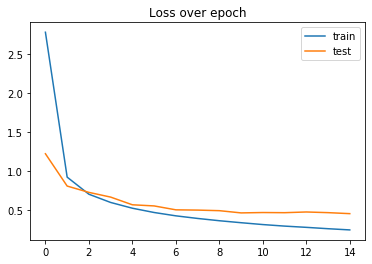

In [36]:
plt.plot(train_stats['Train loss'], label='train')
plt.plot(train_stats['Test loss'], label='test')
plt.title('Loss over epoch')
plt.legend()

run.log_image("loss", plt)

plt.show()

upload complete (accuracy.png)


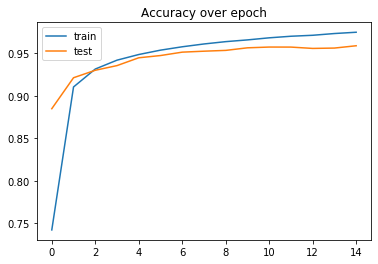

In [37]:
plt.plot(train_stats['Train accuracy'], label='train')
plt.plot(train_stats['Test accuracy'], label='test')
plt.title('Accuracy over epoch')
plt.legend()

run.log_image("accuracy", plt)

plt.show()

## Look at Sample Predictions

d:\pycharmprojects\lexie\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
d:\pycharmprojects\lexie\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
d:\pycharmprojects\lexie\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


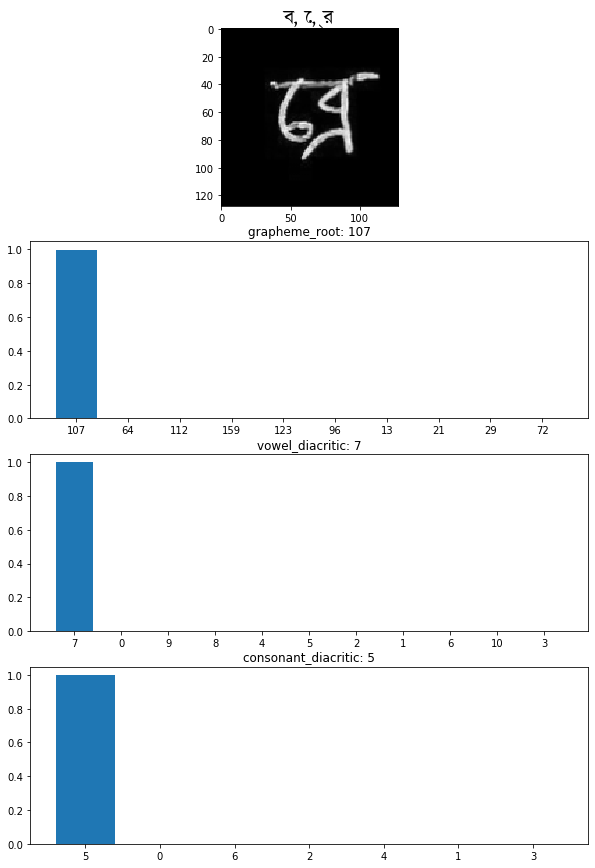

In [38]:
# plot sample train data
model.eval()
for img, labels in testloader:
    img, labels = img.to(device), [label.to(device) for label in labels]
    grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(img)
    
    img = img.cpu()
    grapheme_root = grapheme_root.cpu()
    vowel_diacritic = vowel_diacritic.cpu()
    consonant_diacritic = consonant_diacritic.cpu()
    
    # visualize the inputs
    fig, axs = plt.subplots(4, 1, figsize=(10,15))
    for i in range(0, img.shape[0]):
        axs[0].imshow(TF.to_pil_image(img[i].reshape(SIZE, SIZE)), cmap='gray')
        
        prop = FontProperties()
        prop.set_file('./kalpurush.ttf')
        grapheme_root_str = class_map[(class_map.component_type == 'grapheme_root') \
                                  & (class_map.label == int(labels[0][i]))].component.values[0]
        
        vowel_diacritic_str = class_map[(class_map.component_type == 'vowel_diacritic') \
                                  & (class_map.label == int(labels[1][i]))].component.values[0]
        
        consonant_diacritic_str = class_map[(class_map.component_type == 'consonant_diacritic') \
                                  & (class_map.label == int(labels[2][i]))].component.values[0]
        
        axs[0].set_title('{}, {}, {}'.format(grapheme_root_str, vowel_diacritic_str, consonant_diacritic_str), 
                         fontproperties=prop, fontsize=20)
        
        # analyze grapheme root prediction
        ps_root = F.softmax(grapheme_root[i])
        top10_p, top10_class = ps_root.topk(10, dim=0)
        
        top10_p = top10_p.detach().numpy()
        top10_class = top10_class.detach().numpy()
        
        axs[1].bar(range(len(top10_p)), top10_p)
        axs[1].set_xticks(range(len(top10_p)))
        axs[1].set_xticklabels(top10_class)
        axs[1].set_title('grapheme_root: {}'.format(labels[0][i]))
        
        # analyze vowel prediction
        ps_vowel = F.softmax(vowel_diacritic[i])
        top11_p, top11_class = ps_vowel.topk(11, dim=0)
        
        top11_p = top11_p.detach().numpy()
        top11_class = top11_class.detach().numpy()
        
        axs[2].bar(range(len(top11_p)), top11_p)
        axs[2].set_xticks(range(len(top11_p)))
        axs[2].set_xticklabels(top11_class)
        axs[2].set_title('vowel_diacritic: {}'.format(labels[1][i]))
        
        # analyze consonant prediction
        ps_cons = F.softmax(consonant_diacritic[i])
        top7_p, top7_class = ps_cons.topk(7, dim=0)
        
        top7_p = top7_p.detach().numpy()
        top7_class = top7_class.detach().numpy()
        
        axs[3].bar(range(len(top7_p)), top7_p)
        axs[3].set_xticks(range(len(top7_p)))
        axs[3].set_xticklabels(top7_class)
        axs[3].set_title('consonant_diacritic: {}'.format(labels[2][i]))
        
        plt.show()
        break;
        
    break;

## Create Submission

Initialize test dataset and visualize sample test images:

In [40]:
# initialize train dataset
test_dataset = BengaliDataset(test, transform, test_labels, validation = True)

In [41]:
sample_validloader = DataLoader(test_dataset, batch_size=5, shuffle=True, num_workers=0)

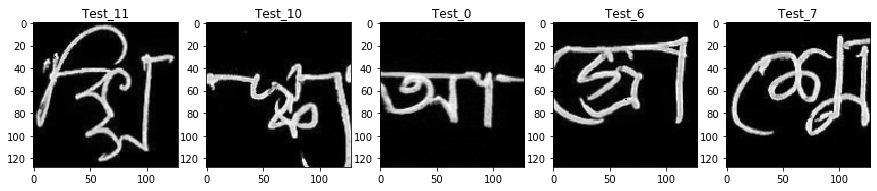

In [42]:
# plot sample train data
for img, image_ids in sample_validloader:
    fig, axs = plt.subplots(1, img.shape[0], figsize=(15,10))
    for i in range(0, img.shape[0]):
        axs[i].imshow(TF.to_pil_image(img[i].reshape(SIZE, SIZE)), cmap='gray')
        axs[i].set_title(image_ids[i])
    break;

Make predictions for the test set:

In [43]:
validloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [44]:
def get_predicted_label(ps):
    ps = F.softmax(ps)[0]
    top_p, top_class = ps.topk(1, dim=0)
        
    top_p = top_p.detach().numpy()
    top_class = top_class.detach().numpy()
    
    return top_class[0]

In [45]:
submission = pd.DataFrame(columns=['row_id', 'target'])

for imgs, image_ids in validloader:
    img = imgs[0]
    image_id = image_ids[0]
    
    imgs = imgs.to(device)
    
    grapheme_root, vowel_diacritic, consonant_diacritic  = model.forward(imgs)
    
    imgs = imgs.cpu()
    grapheme_root = grapheme_root.cpu()
    vowel_diacritic = vowel_diacritic.cpu()
    consonant_diacritic = consonant_diacritic.cpu()
    
    grapheme_root_label = get_predicted_label(grapheme_root)
    vowel_diacritic_label = get_predicted_label(vowel_diacritic)
    consonant_diacritic_label = get_predicted_label(consonant_diacritic)
    
    submission = submission.append({'row_id':str(image_id)+'_grapheme_root', 'target':grapheme_root_label}, 
                                   ignore_index=True)
    submission = submission.append({'row_id':str(image_id)+'_vowel_diacritic', 'target':vowel_diacritic_label}, 
                                   ignore_index=True)
    submission = submission.append({'row_id':str(image_id)+'_consonant_diacritic', 'target':consonant_diacritic_label}, 
                                   ignore_index=True)

d:\pycharmprojects\lexie\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [46]:
submission

,row_id,target
0,Test_0_grapheme_root,3
1,Test_0_vowel_diacritic,1
2,Test_0_consonant_diacritic,0
3,Test_1_grapheme_root,93
4,Test_1_vowel_diacritic,2
5,Test_1_consonant_diacritic,0
6,Test_2_grapheme_root,19
7,Test_2_vowel_diacritic,0
8,Test_2_consonant_diacritic,0
9,Test_3_grapheme_root,115


In [47]:
submission.to_csv('submission.csv')